In [186]:
#Import the neccessary libraries
#Libraries for Loading the dataset and EDA
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#Libraries for NLPP
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re

In [187]:
#Load the datatset
tweets = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')
tweets.head(35)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [188]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [189]:
tweets.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [190]:
tweets.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [191]:
tweets.head(25)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [192]:
#drop missing data in tweet_text
tweets.dropna(subset =['tweet_text'], inplace = True)

In [193]:
tweets.head(25)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion


In [194]:
#handle the missing data
tweets['emotion_in_tweet_is_directed_at'].fillna('Unknown', inplace = True)

C:\Users\User\AppData\Local\Temp\ipykernel_18760\2649023659.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tweets['emotion_in_tweet_is_directed_at'].fillna('Unknown', inplace = True)


In [195]:
#check if values are filled
tweets.isnull().sum()

tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

In [196]:
#Check the groupings of the dataset
tweets.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

In [197]:
#reduce the options for s_there_an_emotion_directed_at_a_brand_or_product
tweets['is_there_an_emotion_directed_at_a_brand_or_product'] = tweets['is_there_an_emotion_directed_at_a_brand_or_product'].replace(["No emotion toward brand or product","I can't tell"], 'Neutral')
tweets.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
Neutral             5544
Positive emotion    2978
Negative emotion     570
Name: count, dtype: int64

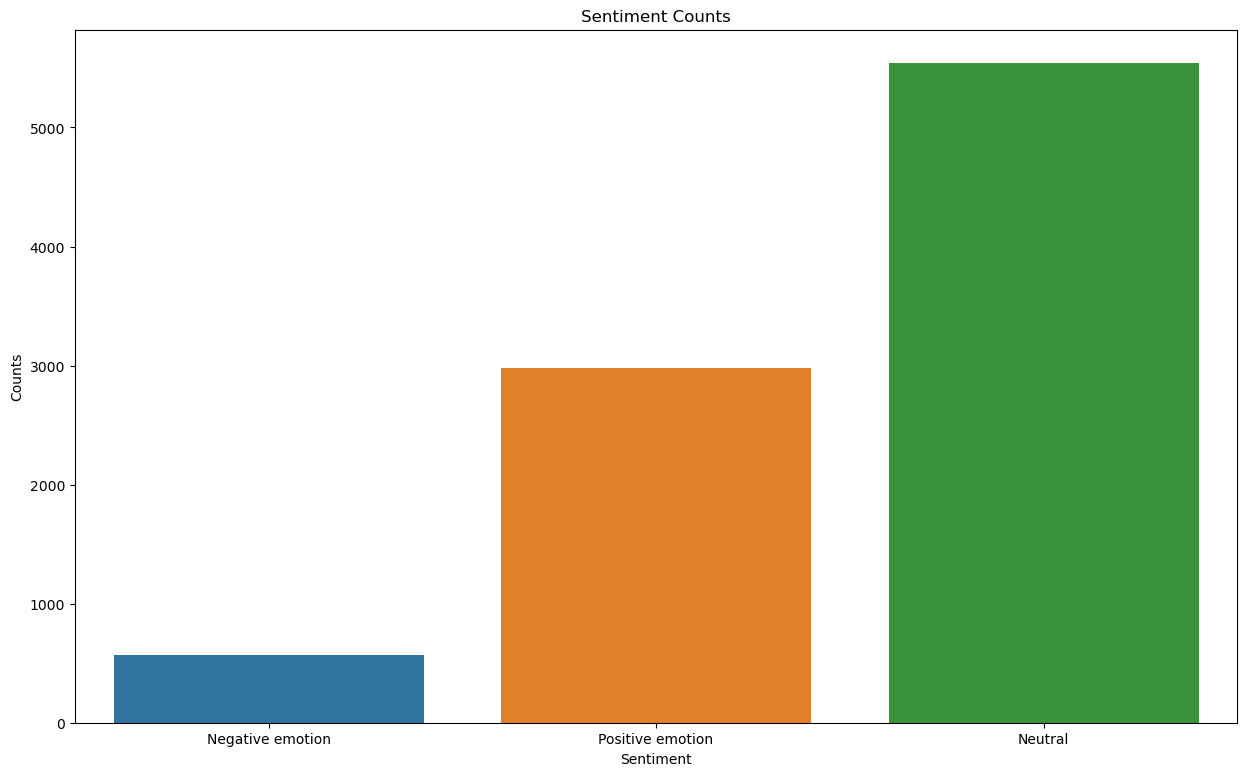

In [198]:
#plot the distribution of the count for is_there_an_emotion_directed_at_a_brand_or_product
plt.figure(figsize=(15,9))
sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data = tweets)
plt.title('Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.show()


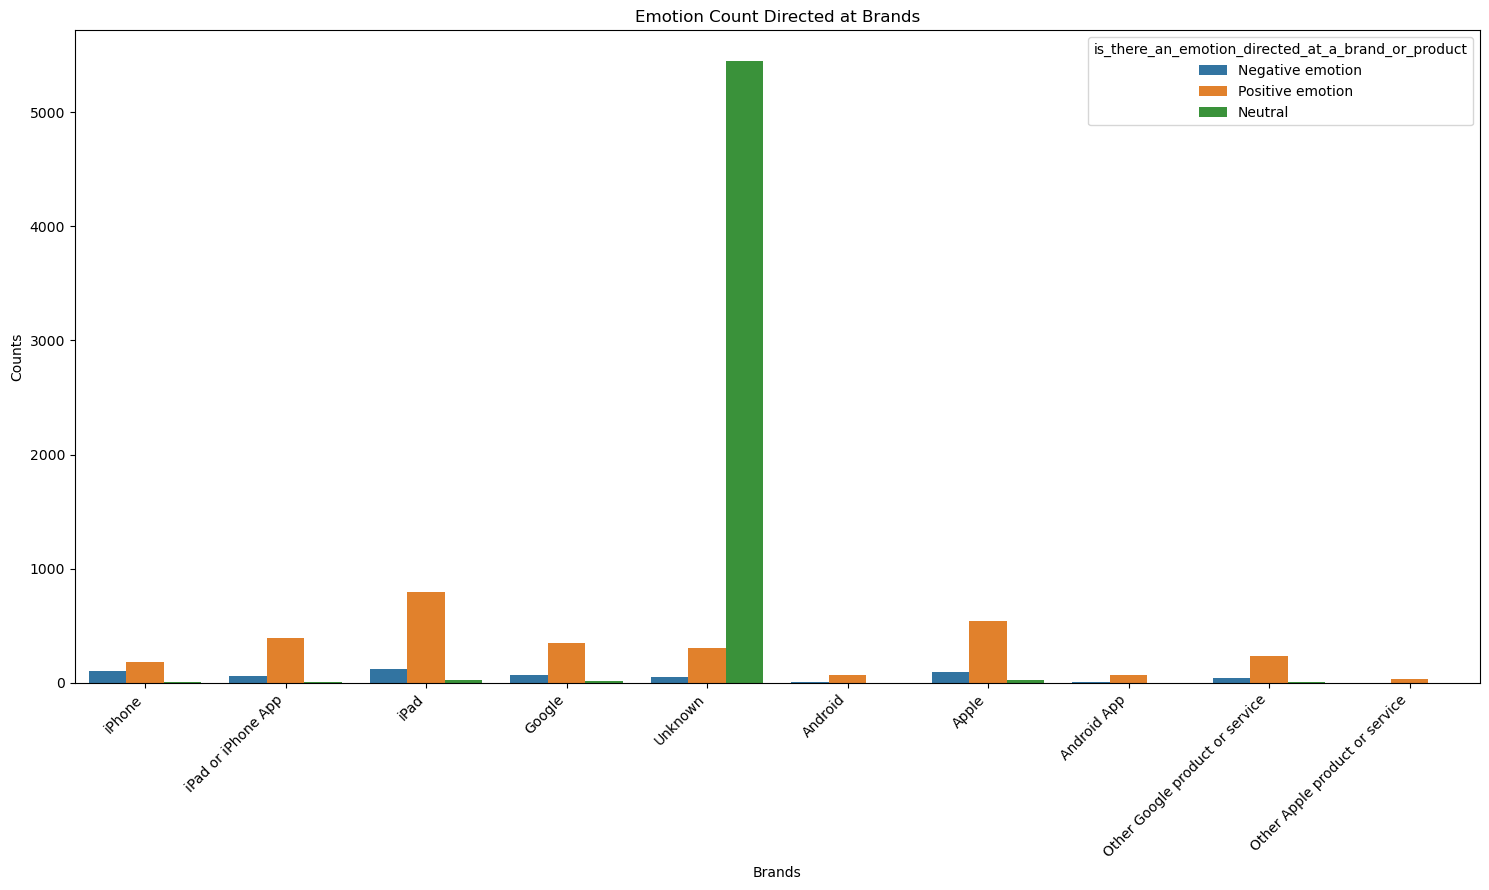

In [199]:
#plot the distribution of the count for is_there_an_emotion_directed_at_a_brand_or_product
plt.figure(figsize=(15,9))
sns.countplot(x='emotion_in_tweet_is_directed_at', hue = 'is_there_an_emotion_directed_at_a_brand_or_product',data = tweets)
plt.title('Emotion Count Directed at Brands')
plt.xlabel('Brands')
plt.ylabel('Counts')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()


In [200]:
#Preprocess the text
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_tweet_text(text):
    text = text.lower()
    # Remove mentions, hashtags, and URLs
    text = re.sub(r'@\w+|#\w+|http\S+|www\S+|https\S+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize text using `tokenizer`
    tokens = tokenizer.tokenize(text)
     # Remove stopwords using `stopwords_list`
    clean_text = [word for word in tokens if word not in stop_words]
    #Perform stemming
    clean_text = [lemmatizer.lemmatize(word) for word in clean_text]  
    return clean_text 

In [201]:
tweets.head(35)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Unknown,Neutral
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion


In [202]:
#clean the tweet_text column
tweets['clean_tweet_text'] = tweets['tweet_text'].apply(lambda x: clean_tweet_text(x))

In [203]:
#Take a look to see the new column created
tweets.head(55)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,clean_tweet_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[iphone, hr, tweeting, dead, need, upgrade, pl..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[know, awesome, ipadiphone, app, youll, likely..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[wait, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[hope, year, festival, isnt, crashy, year, iph..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[great, stuff, fri, marissa, mayer, google, ti..."
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Unknown,Neutral,"[new, ipad, apps, communication, showcased, co..."
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,"[starting, around, corner, hop, skip, jump, go..."
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,"[beautifully, smart, simple, idea, wrote, ipad..."
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,"[counting, day, plus, strong, canadian, dollar..."
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,"[excited, meet, show, sprint, galaxy, still, r..."


In [ ]:
tweets.emotion_in_tweet_is_directed_at.dropna(subset='Unknown')